In this workbook we will be introducing you to a series of models called AutoRegressive models, which can often be more effective than what we have seen so far. These models require more work in setting up, and you must be confident when justifying why you have used these models.

We will be using the same data as before:

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings("ignore")

sales=pd.read_csv('store_sales.csv')
sales['Date']=pd.to_datetime(sales.Date, dayfirst=True, format="%d/%m/%Y") #convert date column to datetime
sales_index=sales.copy()
sales_index.set_index('Date',inplace=True) #create dataframe with date as index
sales_by_week=sales_index.resample('w').sum() #create dataframe showing sales by week
sales_by_week = sales_by_week[:-1] #remove the last data point
sales_by_week.head()

,sales,onpromotion
Date,,
2013-01-06,27728.143012,0
2013-01-13,36970.075954,0
2013-01-20,36721.333008,0
2013-01-27,34954.864030,0
2013-02-03,34247.464011,0


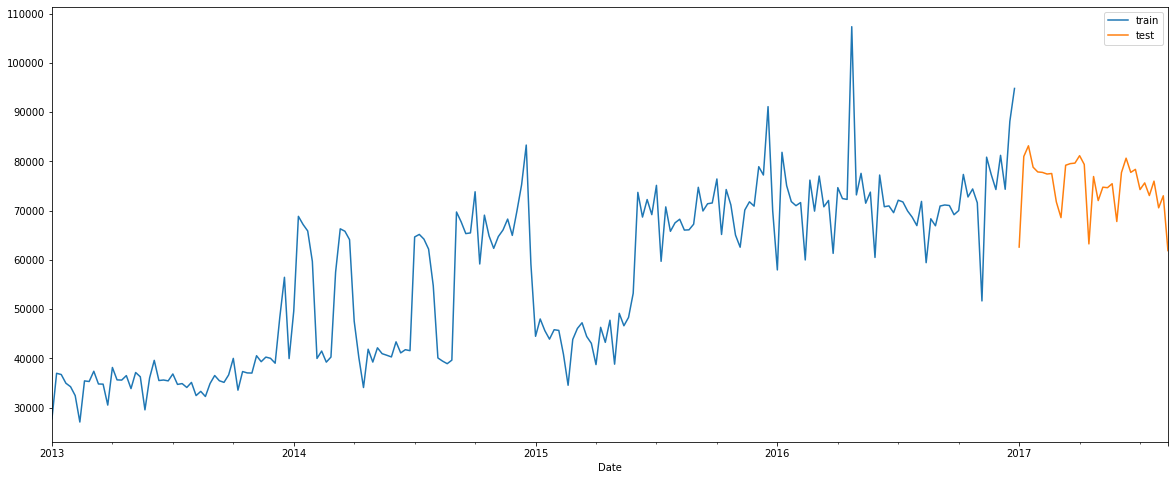

In [2]:
train=sales_by_week['2013':'2016'] # create training dataset
test=sales_by_week['2017'] # create test dataset

fig, ax = plt.subplots(figsize=(20,8))
train.sales.plot(ax=ax,label='train')
test.sales.plot(ax=ax,label='test')
plt.legend()
plt.show()

## Autoregressive methods

In the previous models we were able to account for seasonality and trends within the data, but we are still ignoring the autocorrelation between observations- that is how related they are to each other. For example, sales on Saturday's are likely to be similar as well consecutive days if a sale has been on.

With this family of models we will be able to also account for autocorrelation. 

<b>Note for your EPA:</b> these models require careful parameter selection, that is, you must carefully investigate the data to decide on exactly what model you are going to use. In your interview, it is likely you will be asked why you chose the model and parameters you did, you will need to be confident and correct in your response, so make sure you do your research thoroughly.

The first two models we will look at are Autoregression and Moving Average. Both have their own advantages and disadvantages, and suit different types of data. We will introduce both, before looking at how we determine which one is most appropriate:

### 1. Autoregression (AR)

The simplest model within the family, this approach predicts each new forecasted value based on the residuals (error) from its previous predictions.

<b> Advantages</b> of Autoregression:
<ul>
    <li> Effective at identifying patterns based off autocorrelations </li>
</ul>

<b> Disadvantages</b> of Autoregression:

<ul>
    <li> Not very sophisticated when considering trends or seasonality </li>
    <li> Requires the data to be stationary </li>
</ul>

When working with an AR model, we need to identify the <b> autoregressive order (p) </b>, this is the number of significant non-zero lags (ignoring the first one) on a PACF drops before they drop into the blue band. 

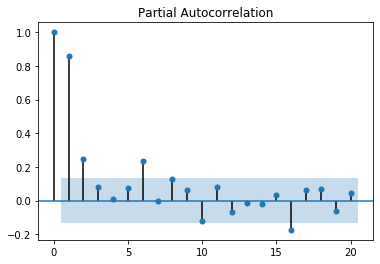

In [33]:
from statsmodels.graphics.tsaplots import plot_pacf


plot_pacf(train.sales,lags=20) 
plt.show()

With our weekly sales data, this happens at lag 2, so our autoregressive order (p) = 2.

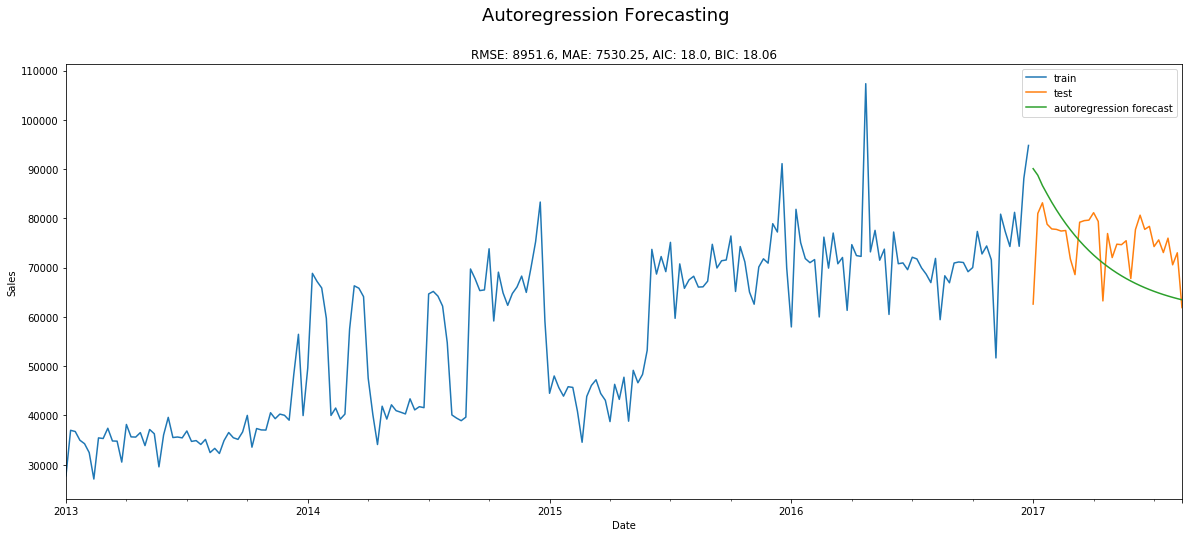

In [36]:
from statsmodels.tsa.ar_model import AutoReg
from sklearn.metrics import mean_squared_error, mean_absolute_error

# create AutoReg model with 2 lags
ar = AutoReg(train.sales,lags=2).fit()

test_ar=test.copy() # create test set for this example

# To use this function for prediction you need to provide the first and last date
test_ar['predicted']=ar.predict(start=test_ar.index[0],end=test_ar.index[-1]) 

# calculate errors and round to 2 d.p
rmse_ar=round(np.sqrt(mean_squared_error(test_ar.sales,test_ar.predicted)),2)
mae_ar=round(mean_absolute_error(test_ar.sales,test_ar.predicted),2)
aic_ar=round(ar.aic,2)
bic_ar=round(ar.bic,2)

fig, ax = plt.subplots(figsize=(20,8))
train.sales.plot(ax=ax,label='train')
test_ar.sales.plot(ax=ax,label='test')
test_ar.predicted.plot(ax=ax,label='autoregression forecast')
plt.legend()
plt.title('RMSE: '+str(rmse_ar)+', MAE: '+str(mae_ar)+', AIC: '+str(aic_ar)+', BIC: '+str(bic_ar))
plt.suptitle("Autoregression Forecasting",fontsize=18)
plt.ylabel('Sales')
plt.show()

### 2. Moving Average (MA) 

Not to be confused with the types of model we saw earlier, this is a model that predicts the next step in a time series by looking at residual errors from calculating the average of prior steps.

<b> Advantages</b> of Moving Average:
<ul>
    <li> Is able to deal with slight trends of seasonality </li>
    <li> Is resistant to small random variations in the data </li>
</ul>

<b> Disadvantages</b> of Autoregression:

<ul>
    <li> Does not cope well with rapid changes in the data </li>
    <li> Requires a high degree of stationarity </li>
</ul>

For these types of model, we need to identify the <b> moving average order (q) </b>. This is found by plotting an ACF, and counting how many significant lags occur on an ACF before they drop into the blue band. If there are no significant lags, then a moving average model is not appropriate.

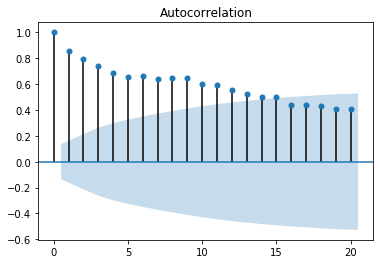

In [35]:
from statsmodels.graphics.tsaplots import plot_acf


plot_acf(train.sales,lags=20) 
plt.show()

WIth our weekly sales, 15 lags (ignoring the first one) occur before they drop into the blue band, making the moving average order (q) = 15.

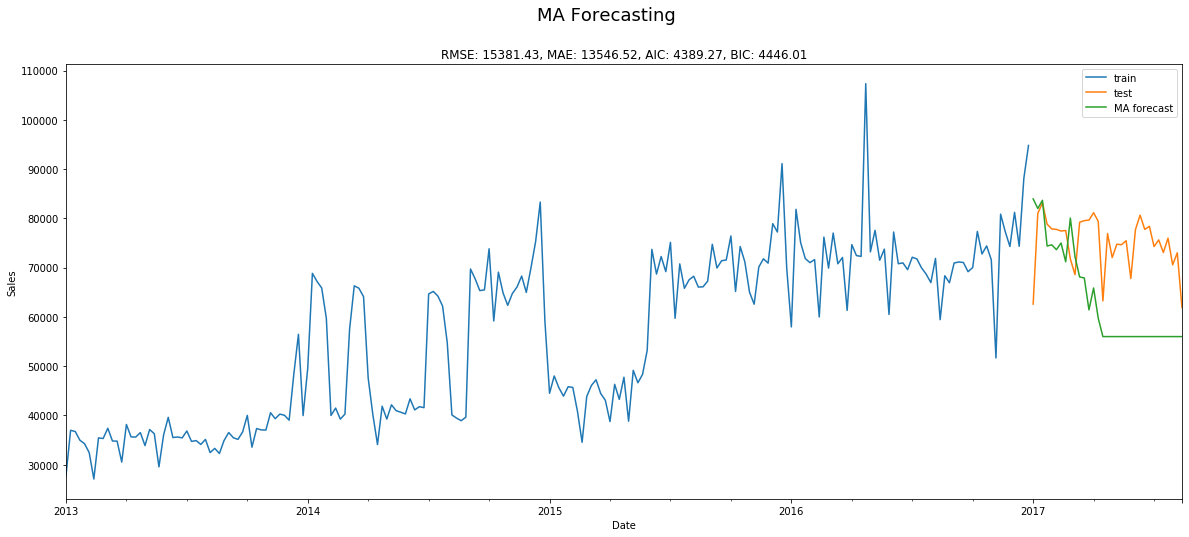

In [37]:
from statsmodels.tsa.arima.model import ARIMA

# create MA model with order 15
ma = ARIMA(train.sales,order=(0,0,15)).fit()

test_ma=test.copy() # create test set for this example

# To use this function for prediction you need to provide the first and last date
test_ma['predicted']=ma.predict(start=test_ma.index[0],end=test_ma.index[-1]) 

# calculate errors and round to 2 d.p
rmse_ma=round(np.sqrt(mean_squared_error(test_ma.sales,test_ma.predicted)),2)
mae_ma=round(mean_absolute_error(test_ma.sales,test_ma.predicted),2)
aic_ma=round(ma.aic,2)
bic_ma=round(ma.bic,2)

fig, ax = plt.subplots(figsize=(20,8))
train.sales.plot(ax=ax,label='train')
test_ma.sales.plot(ax=ax,label='test')
test_ma.predicted.plot(ax=ax,label='MA forecast')
plt.legend()
plt.title('RMSE: '+str(rmse_ma)+', MAE: '+str(mae_ma)+', AIC: '+str(aic_ma)+', BIC: '+str(bic_ma))
plt.suptitle("MA Forecasting",fontsize=18)
plt.ylabel('Sales')
plt.show()

But how do we know which model to choose?

You should always aim to choose the most appropriate model for your data, and both so far have different strengths. A useful way to decide between AR and MA models is to compare the ACF and PACF plots for your data. 

If the ACF shows the lags <i> tailing off </i> while the PACF shows a <i>cut off after a number of significant lags</i>, then select an AR model. If the opposite is true, select an MA model (as seen in the table below). 

|  | AR(p) | MA(q) |
| --- | --- | --- |
| ACF | Tails off (Geometric decay) | Significant at each lag q/ Cuts off after lag q |
| PACF | Significant at each lag p/ Cuts off after lag p | Tails off (Geometric decay) |

If neither is true, then neither model is suitable.

Let's look at the ACF and PACF for our data again:

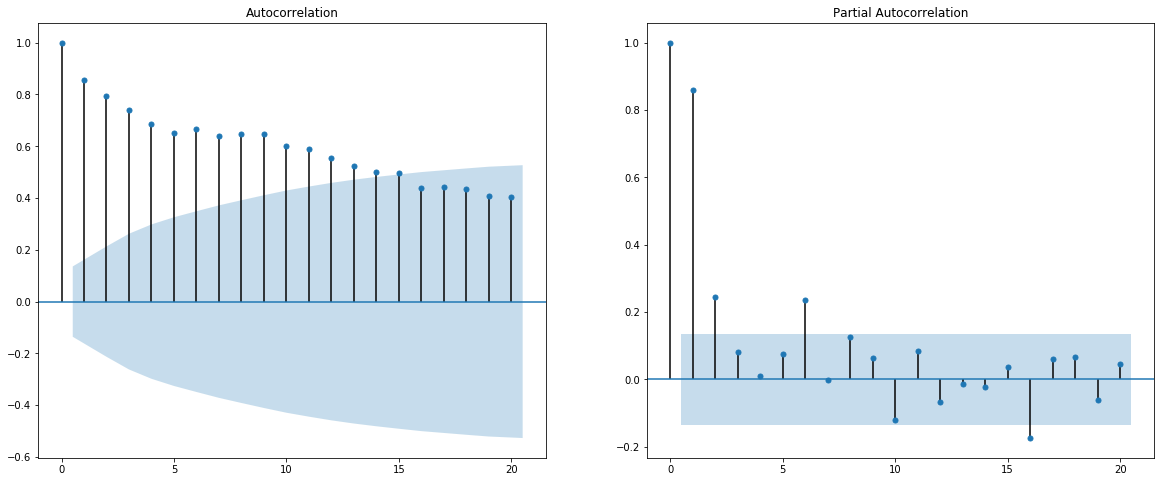

In [45]:
fig, ax = plt.subplots(ncols=2, figsize=(20,8))

plot_acf(train.sales,lags=20,ax=ax[0]) 
plot_pacf(train.sales,lags=20,ax=ax[1]) 
plt.show()

For our data, the ACF is showing a tail off while the PACF is showing a cut off. Therefore, the AR model is more suitable for our data. 

For both AR and MA, the <b> order </b> can be found by looking at the number of signifiant non-zero lags (ignoring the first) in these plots. For <b> autoregression </b> look at the PACF, and for <b> moving average </b> look at the ACF. 

This also provides another way of determining which model is best, as if the order is <b> large </b> (in this case MA), then that would suggest the model will be overly complex. When forecasting, simplicity is best.

No matter which model you pick, you need to be careful in selecting your parameters (autoregression and/or moving average order) and be prepeared to explain/justify why you selected them.

### 3. Autoregressive Integrated Moving Average (ARIMA)

A step up from an autorgressive function, we have ARIMA which combines the autoregression model with a moving average model as well as preprocessing step to make the data stationary, called integration.

<b> Advantages</b> of ARIMA:
<ul>
    <li> Effective at finding patterns in time series data based on differences in observations </li>
    <li> Takes into account trends </li>
</ul>

<b> Disadvantages</b> of ARIMA:

<ul>
    <li> Doesn't handle seasonality well </li>
</ul>

With ARIMA we need to supply three values to an order to tell it what sort of model we want:

<ul>
    <li><b>p</b>- The order of autoregression (see autoregression models)</li>
    <li><b>d</b>- The integrative part of the model, how many 'differences' to be taken between observations to make it stationary (leave 0 if already stationary, if linear trend d=1)</li>
    <li><b>q</b>- The moving average order (see moving average models)</li>
</ul>

You can break down ARIMA to AR - I - MA with with p representing AR, d represting I and q representing MA.

If you set the order as (1, 0, 0) you get an Autoregressive model and (0, 0, 1) you would get a moving average model.

But how do you know what to pick for each one?

First we need to consider d, is the time series stationary? If it is you can set d=0, otherwise you need to set it to how many times you need to difference the observations to make it stationary.

Let's see if the data is stationary by performing an Augmented Dickey-Fuller test.

And we will test this at the 5% level.

In [46]:
from statsmodels.tsa.stattools import adfuller

result = adfuller(train.sales)
print('p-value:' +str(result[1]))

p-value:0.5802180526000823


Therefore we fail to reject the null hypothesis and the data is not stationary (which we already knew), so d has to be at least 1. Let's try differencing the model and see if that has an effect:

In [48]:
# Create first order difference

train['difference']=train.sales.diff(periods = 1)

p-value:0.5802180526000823


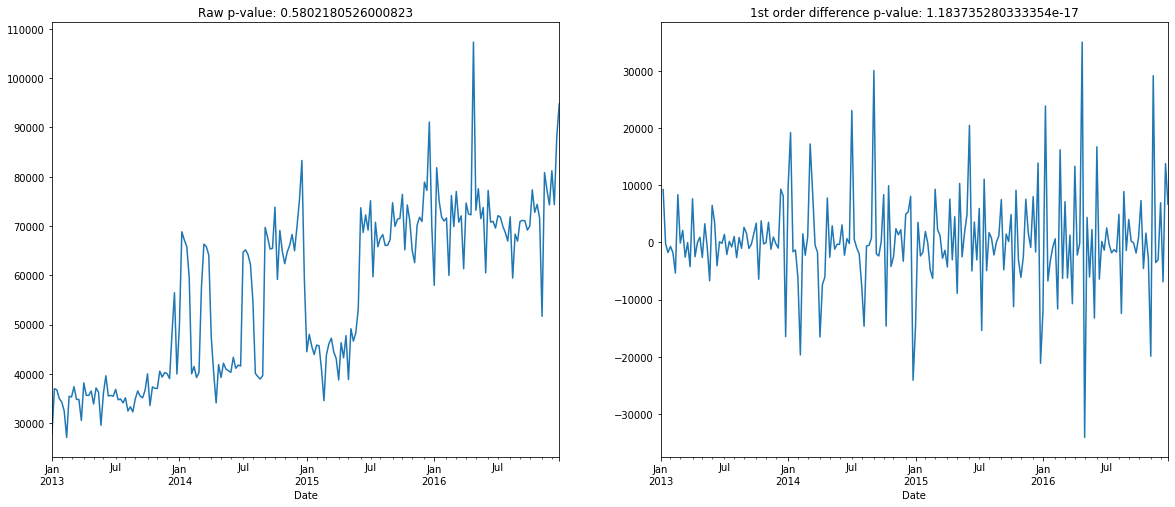

In [49]:
# Calculate new p-value
result_diff = adfuller(train.difference.dropna())
print('p-value:' +str(result[1]))
# plot two charts for comparison

fig, ax = plt.subplots(ncols=2,figsize=(20,8))
train.sales.plot(ax=ax[0])
ax[0].set_title('Raw p-value: '+str(result[1]))
train.difference.plot(ax=ax[1])
ax[1].set_title('1st order difference p-value: '+str(result_diff[1]))
plt.show()

This has shown us that differencing the values once has made the series stationary, so d=1.

If this hadn't made the data stationary, we would repeat the process and keep doing so until it became stationary. The number of times you have to perform this gives you the value of d.

<b>WARNING: total differencing more than twice should be avoided</b>

What about p and q?

From earlier, p is the autoregression order (the number of non-zero lags in a PACF plot) and q is the moving average order (the number of non-zero lags in an ACF plot).

As d=1, we will need to find these values for the differenced data.

<b>Important further rule for selecting parameters</b> 

We also need to look at whether the first significant lag on the ACF is positive or negative:

<ul>
    <li><b>Postive</b> --> Definitely keep the AR terms, p = 1 , could /might drop the MA term (q=0) </li>
    <li><b>Negative</b>--> Definitely keep the MA terms, q = 1, could/ might drop the AR term (p=0)</li>
</ul>

Note: ACF and PACF do not handle null values, so we will need to drop them when making the plots:

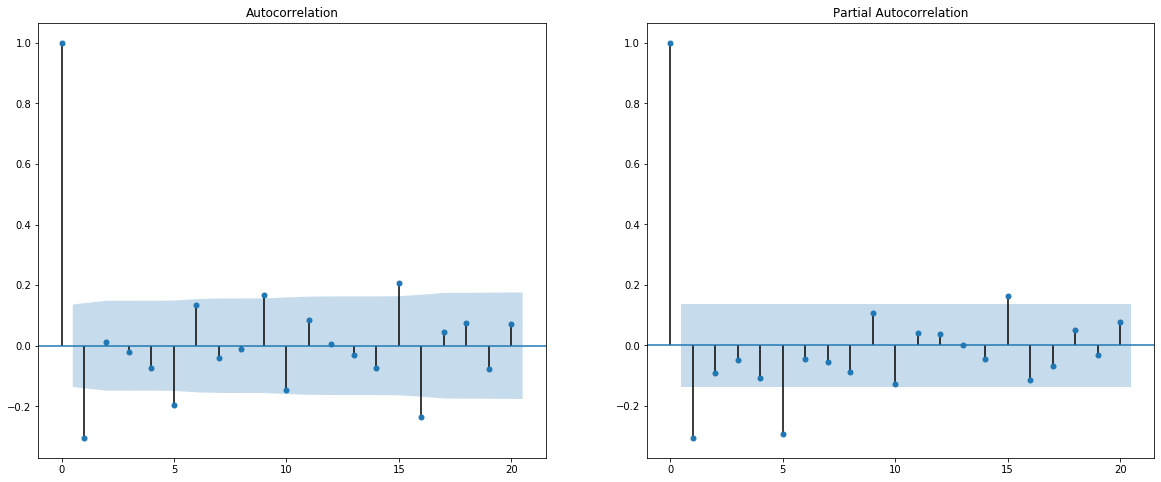

In [51]:
fig, ax = plt.subplots(ncols=2, figsize=(20,8))

plot_acf(train.difference.dropna(),lags=20,ax=ax[0]) 
plot_pacf(train.difference.dropna(),lags=20,ax=ax[1]) 
plt.show()

The PACF has 1 significant non-zero lag, so AR(p)=1. The ACF also has 1 significant non-zero lag, so MA(q)=1. 

For our ARIMA model then, the parameters are (1,1,1)

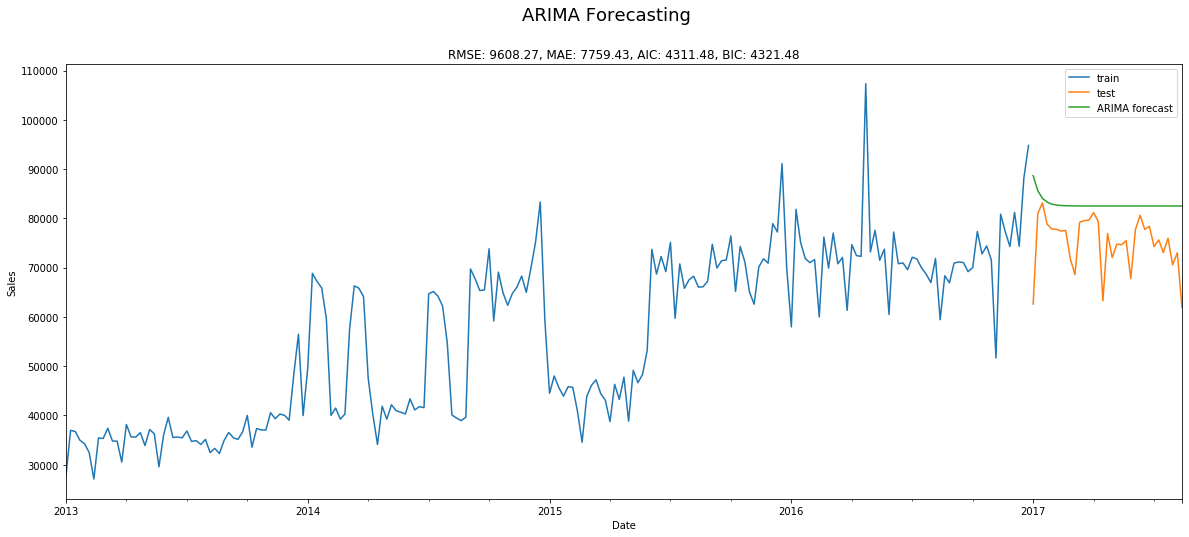

In [52]:
# create ARIMA model with best order
arima = ARIMA(train.sales,order=(1,1,1)).fit()

test_arima=test.copy() # create test set for this example

# To use this function for prediction you need to provide the first and last date
test_arima['predicted']=arima.predict(start=test_arima.index[0],end=test_arima.index[-1]) 

# calculate errors and round to 2 d.p
rmse_arima=round(np.sqrt(mean_squared_error(test_arima.sales,test_arima.predicted)),2)
mae_arima=round(mean_absolute_error(test_arima.sales,test_arima.predicted),2)
aic_arima=round(arima.aic,2)
bic_arima=round(arima.bic,2)

fig, ax = plt.subplots(figsize=(20,8))
train.sales.plot(ax=ax,label='train')
test_arima.sales.plot(ax=ax,label='test')
test_arima.predicted.plot(ax=ax,label='ARIMA forecast')
plt.legend()
plt.title('RMSE: '+str(rmse_arima)+', MAE: '+str(mae_arima)+', AIC: '+str(aic_arima)+', BIC: '+str(bic_arima))
plt.suptitle("ARIMA Forecasting",fontsize=18)
plt.ylabel('Sales')
plt.show()

As the first significant lag was zero, we could consider dropping the AR term from our model (p=0), making our parameters (0,1,1):

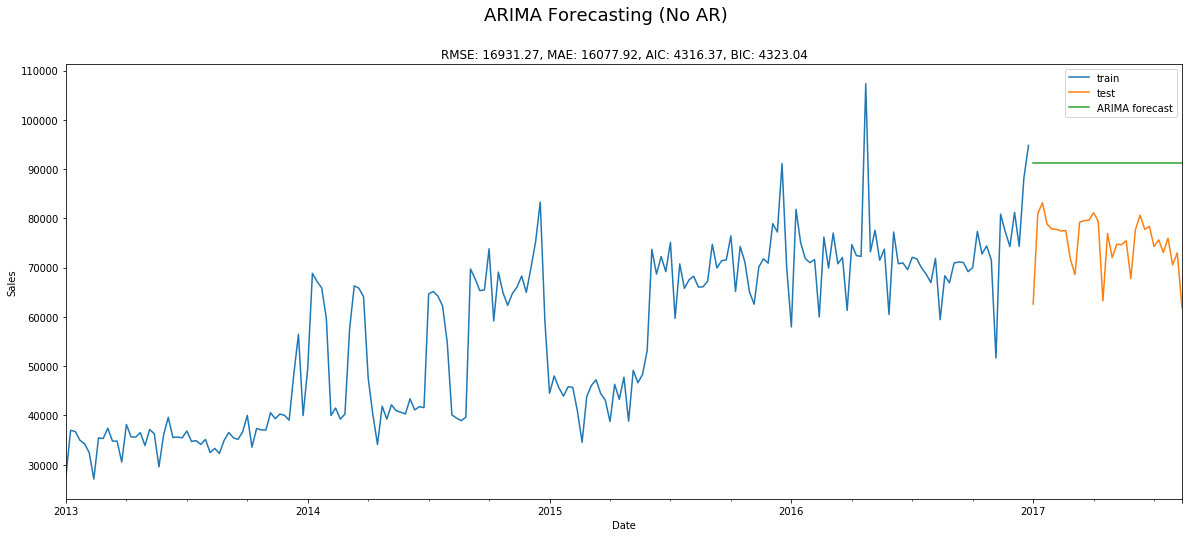

In [55]:
arima_no_AR = ARIMA(train.sales,order=(0,1,1)).fit()

test_arima_no_AR=test.copy() # create test set for this example

# To use this function for prediction you need to provide the first and last date
test_arima_no_AR['predicted']=arima_no_AR.predict(start=test_arima_no_AR.index[0],end=test_arima_no_AR.index[-1]) 

# calculate errors and round to 2 d.p
rmse_arima_no_AR=round(np.sqrt(mean_squared_error(test_arima_no_AR.sales,test_arima_no_AR.predicted)),2)
mae_arima_no_AR=round(mean_absolute_error(test_arima_no_AR.sales,test_arima_no_AR.predicted),2)
aic_arima_no_AR=round(arima_no_AR.aic,2)
bic_arima_no_AR=round(arima_no_AR.bic,2)

fig, ax = plt.subplots(figsize=(20,8))
train.sales.plot(ax=ax,label='train')
test_arima_no_AR.sales.plot(ax=ax,label='test')
test_arima_no_AR.predicted.plot(ax=ax,label='ARIMA forecast')
plt.legend()
plt.title('RMSE: '+str(rmse_arima_no_AR)+', MAE: '+str(mae_arima_no_AR)+', AIC: '+str(aic_arima_no_AR)+', BIC: '+str(bic_arima_no_AR))
plt.suptitle("ARIMA Forecasting (No AR)",fontsize=18)
plt.ylabel('Sales')
plt.show()

## Seasonal Autoregressive Integrated Moving Average (SARIMA) 

While ARIMA takes into account trend, it doesn't think about seasonality. This is where SARIMA comes in, it models the next step in the time series sequence based off differenced observations, error and differences in seasonal observations. 

If your data does not have seasonality, you will be fine using ARIMA.

<b> Advantages</b> of SARIMA:
<ul>
    <li> Effective at finding patterns in time series data based on differences in observations </li>
    <li> Takes into account seasonality </li>
</ul>

With this model, we still need to pass in the same order as before, but also need to pass in a `seasonal_order` which has the following inputs:

<ul>
    <li><b>D</b>- The number of differences needed to make the seasonal part of the time series stationary </li>
    <li><b>P</b>- The seasonal autoregression order</li>
    <li><b>Q</b>- The seasonal moving average order</li>
    <li><b>M</b>- How many observations to include in a season (i.e. 12 for monthly data with yearly season)</li>
</ul>

So a complete SARIMA will have paramaters (p, d, q) from the ARIMA part and (P, D, Q, M) from the seasonal part.

To find D, P and Q we follow the same process as before, only this time we need to look only at the seasonal part of the data, which we can find using the `seasonal_decompose` function from the last workshop.

<Figure size 432x288 with 0 Axes>

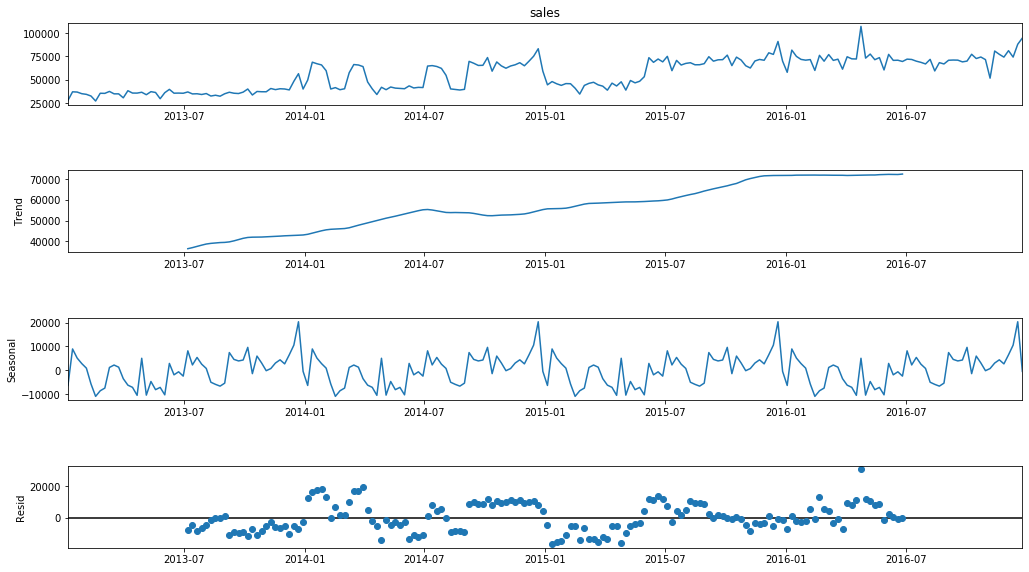

In [56]:
from statsmodels.tsa.seasonal import seasonal_decompose

decompose = seasonal_decompose(train.sales, period=52)  

fig = plt.figure()  
fig = decompose.plot() 
fig.set_size_inches((16, 9))

For strongly seasonal data you will need to difference your training data seasonally. If not stationary after this you may also need to undertake simple differencing (as we did for the ARIMA model above).

To demonstrate seasonal differencing for this guide we will assume that simple and seasonal differencing is required in this situation and take the data we already simply differenced above and apply seasonal differecning in addition

To seasonally difference you use .diff() with the argument in the brackets being our seasonal period. Our data is weekly and the seasonal period is a year, so the lags will be 52.

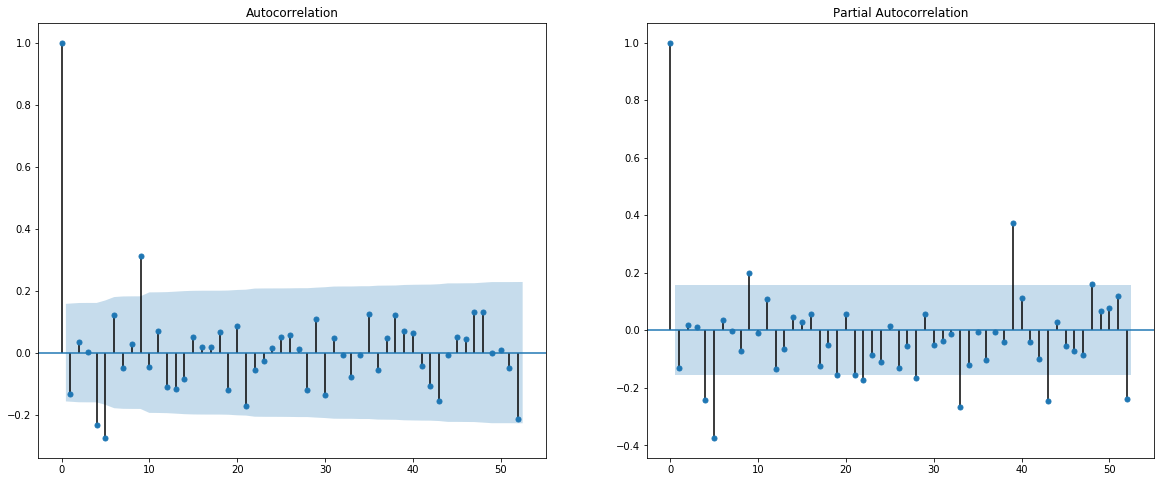

In [66]:
fig, ax = plt.subplots(ncols=2, figsize=(20,8))

plot_acf(train.difference.diff(52).dropna(),lags=52,ax=ax[0]) 
plot_pacf(train.difference.diff(52).dropna(),lags=52,ax=ax[1]) 
plt.show()

We have now undertaken simple differencing (d) and seasonal differencing (D) on our data, so we make d=1 and D=1. 

We will look to redefine out simple AR MA terms (p, q) as we have differenced again so they may have changed.
<ul>
    <li><b>p</b> look at partial autocorrelation function plot, there are no significant non-zero lags, so p=0 </li>
    <li><b>q</b> look at the autocorrelation function plot, again there are no significant non-zero lags, so q=0 </li>
</ul>

As the second lag on the ACF plot is negative, we can keep the MA part and drop the AR part (p=0 and q=1).

So for the ARIMA part of the model, the parameters will be (0, 1, 1).

For the seasonal terms of the model, P and Q, we need to look at the PACF and ACF plots respectively but our focus is now on our seasonal period (M). For M, this just comes from how we are defining a seasonal period. As our data is weekly and the seasonal pattern repeats once a year, 52 observations make a year so M = 52. 

Typically you would invesitage multiple repetitions of the seasonal period in the ACF/PACFs however, in this example we can't push the ACF and PACF to show mulitple repetitions of our season due to the length of our dataset so we stick to lags = 52 for the ACF / PCF.

<ul>
    <li><b>P</b> Look again at the partial autocorrelation function plot. How many significant multiples of the seasonal period? i.e. starting at lag 52, how many significant non-zero lags are there? In this case there is 1, but we have only included one seasonal period due to the size of the dataset, so there might be more. </li>
    <li><b>Q</b> Look again at the autocorrelation function plot. How many significant multiples of the seasonal period? i.e. starting at lag 52, how many significant non-zero lags are there? In this case there are none. </li>
</ul>

We should also check whether the 52nd lag is positive or negative, as this is the Mth lag.

<b>Postive</b> Definitely keep the seasonal AR terms, P = 0 , could /might drop the seasonal MA term (Q=0)

<b>Negative</b>--> Definitely keep the seasonal MA terms, Q = 1, could/ might drop the seasonal AR term (P=0) 

As the 52nd lag is negative, we can make P = 0 and Q = 1.

Bringing it all together

So for out SARIMA model, the ARIMA part will be (0,1,1) as before and the seasonal order will be (0, 1, 1, 52).

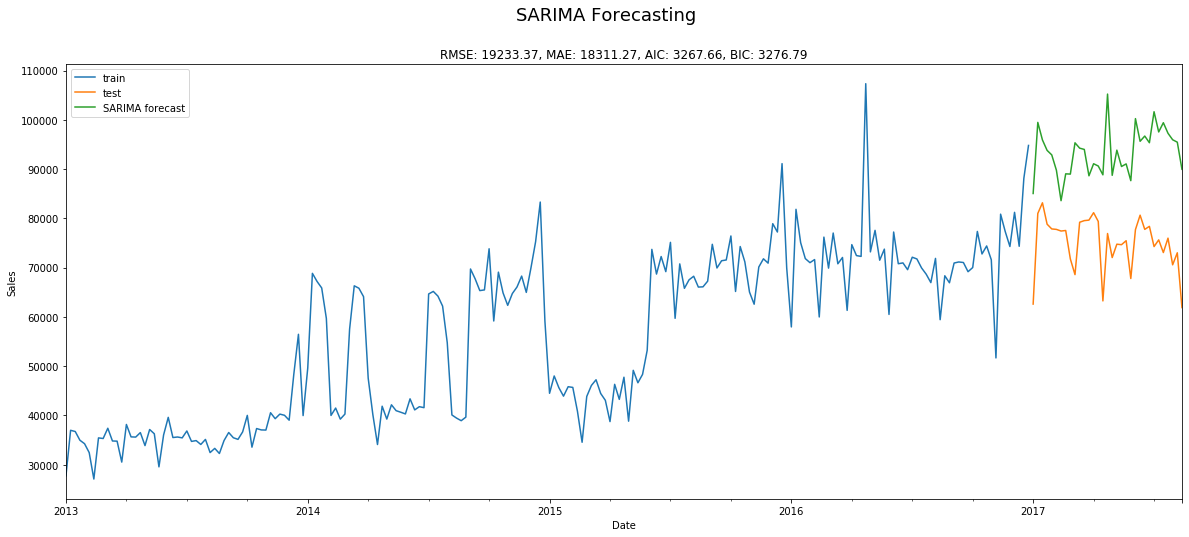

In [69]:
# create SARIMA model with best order and best seasonal_order
sarima = SARIMAX(train.sales,order=(0,1,1),seasonal_order=(0,1,1,52)).fit()

test_sarima=test.copy() # create test set for this example

# To use this function for prediction you need to provide the first and last date
test_sarima['predicted']=sarima.predict(start=test_sarima.index[0],end=test_sarima.index[-1]) 

# calculate errors and round to 2 d.p
rmse_sarima=round(np.sqrt(mean_squared_error(test_sarima.sales,test_sarima.predicted)),2)
mae_sarima=round(mean_absolute_error(test_sarima.sales,test_sarima.predicted),2)
aic_sarima=round(sarima.aic,2)
bic_sarima=round(sarima.bic,2)

fig, ax = plt.subplots(figsize=(20,8))
train.sales.plot(ax=ax,label='train')
test_sarima.sales.plot(ax=ax,label='test')
test_sarima.predicted.plot(ax=ax,label='SARIMA forecast')
plt.legend()
plt.title('RMSE: '+str(rmse_sarima)+', MAE: '+str(mae_sarima)+', AIC: '+str(aic_sarima)+', BIC: '+str(bic_sarima))
plt.suptitle("SARIMA Forecasting",fontsize=18)
plt.ylabel('Sales')
plt.show()

### Seasonal Autoregressive Integrated Moving Average with Exogenous Regressors (SARIMAX)

The final model we are going to look at today is the SARIMAX, which is SARIMA that also allows us to include covariates, that is parallel time series data that explains what is going on in the data. We call the primary data (sales) <b>endogenous</b> and our secondary <b>exogenous</b>. The secondary variables are used to help predict the primary.

You can add exogenous variables to AR and ARIMA models as well. 

<b> Advantages</b> of SARIMAX:
<ul>
    <li> Effective at finding patterns in time series data based on differences in observations </li>
    <li> Takes into account seasonality </li>
    <li> Takes into account additional information found in other time series</li>
</ul>

For this example, we are going to include the number of items on promotion during each week as the exogenous variable.

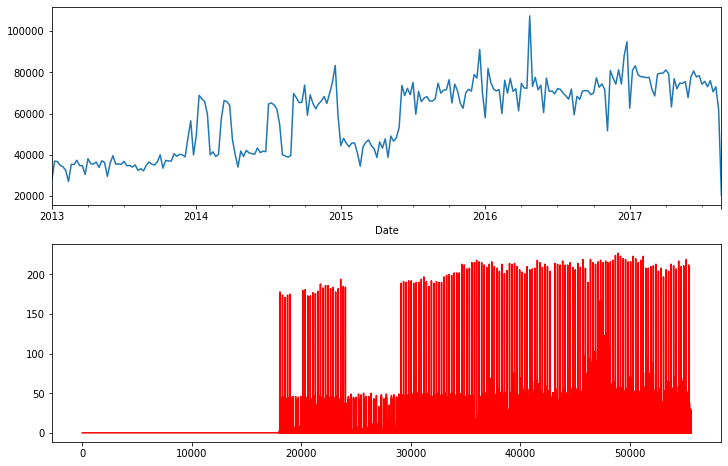

In [46]:
fig, ax = plt.subplots(nrows=2,figsize=(12,8))
sales_by_week.sales.plot(ax=ax[0])
sales.onpromotion.plot(ax=ax[1],color='red')
plt.show()

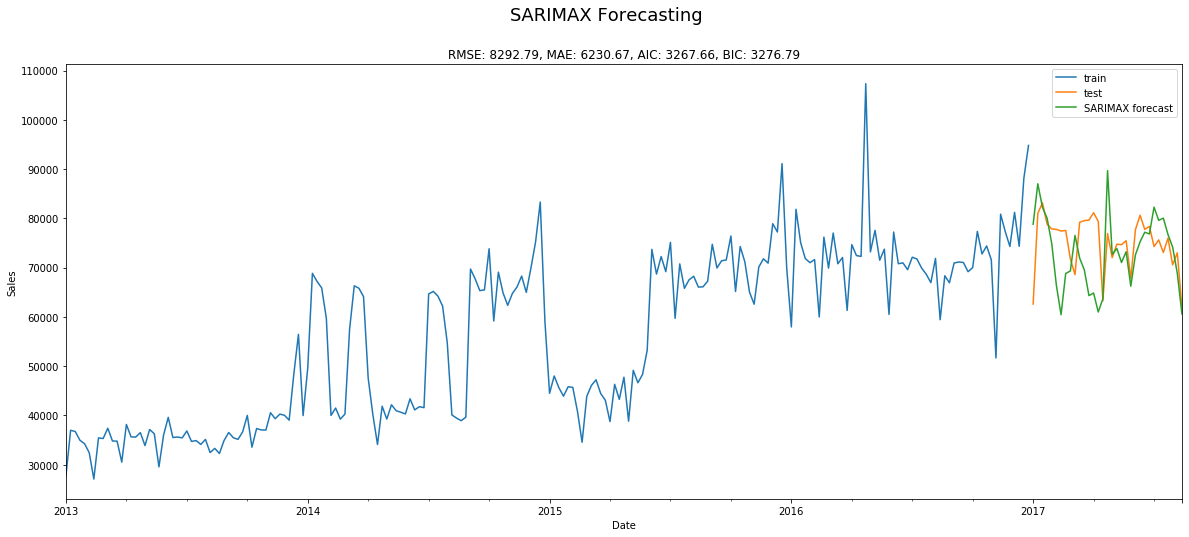

In [70]:
# create SARIMA model with best order and best seasonal_order and promotion info as exogenous

sarimax = SARIMAX(train.sales,exog=train.onpromotion,order=(0,1,1),seasonal_order=(0,1,1,52)).fit()

test_sarimax=test.copy() # create test set for this example

# To use this function for prediction you need to provide the first and last date and the exogenous data
test_sarimax['predicted']=sarimax.predict(start=test_sarimax.index[0],end=test_sarimax.index[-1],exog=test_sarimax.onpromotion) 

# calculate errors and round to 2 d.p
rmse_sarimax=round(np.sqrt(mean_squared_error(test_sarimax.sales,test_sarimax.predicted)),2)
mae_sarimax=round(mean_absolute_error(test_sarimax.sales,test_sarimax.predicted),2)
aic_sarimax=round(sarima.aic,2)
bic_sarimax=round(sarima.bic,2)

fig, ax = plt.subplots(figsize=(20,8))
train.sales.plot(ax=ax,label='train')
test_sarimax.sales.plot(ax=ax,label='test')
test_sarimax.predicted.plot(ax=ax,label='SARIMAX forecast')
plt.legend()
plt.title('RMSE: '+str(rmse_sarimax)+', MAE: '+str(mae_sarimax)+', AIC: '+str(aic_sarimax)+', BIC: '+str(bic_sarimax))
plt.suptitle("SARIMAX Forecasting",fontsize=18)
plt.ylabel('Sales')
plt.show()

Let's now compare the metrics for each of these models to see which performed best:

In [71]:
auto_metrics=pd.DataFrame({'Model':['AR','MA','ARIMA','SARIMA','SARIMAX'],
                           'RMSE':[rmse_ar,rmse_ma,rmse_arima,rmse_sarima,rmse_sarimax],
                           'MAE':[mae_ar,mae_ma,mae_arima,mae_sarima,mae_sarimax],
                           'AIC':[aic_ar,aic_ma,aic_arima,aic_sarima,aic_sarimax],
                           'BIC':[bic_ar,bic_ma,bic_arima,bic_sarima,bic_sarimax]})
auto_metrics

,Model,RMSE,MAE,AIC,BIC
0,AR,8951.60,7530.25,18.00,18.06
1,MA,15381.43,13546.52,4389.27,4446.01
2,ARIMA,16931.27,16077.92,4316.37,4323.04
3,SARIMA,19233.37,18311.27,3267.66,3276.79
4,SARIMAX,8292.79,6230.67,3267.66,3276.79


You should always try multiple models when investigating your data to see which is best.

<b>Step-by-step SARIMAX</b>

1. **Test-Train Split:** Perform a test train split on the dataset (first roughly 80% to decide on parameters, last 20% to see how well our model performs). 


2. **Identify Seasonality:** Identify if the time series is seasonal and, if it is, what is the seasonal period? (The ACF can be helpful with this)


3. **Seasonal Decomposition (Optional):** If the series is seasonal decompose it into its trend and seasonal component to get more information about these components.


4. **Differencing:** Use a combination of seasonal and simple differencing to remove seasonality/trend from the TS. Use the differenced plot, acf and ADFuller test to verify if the TS is stationary.


6. **Manual Parameter Selection:** Once the TS is stationary use the ACF and PACF plots of the stationary series to select the order of the AR and MA terms.


7. **Evaluate model performance:** Use the training data to build your model(s) and compare how the forecast compares to the test data. Use metrics like RMSE to compare model performance.


8. **Deploy your chosen model:** Once you have settled on a model train it on the whole dataset to produce your forecast.

## Practice with seasonal data

In workshop 1 we used a dataset showing the daily minimum temperature in Melbourne between 1981 and 1990 which showed a high degree of seasonality. Using the steps above, build a forecasting model with this data:

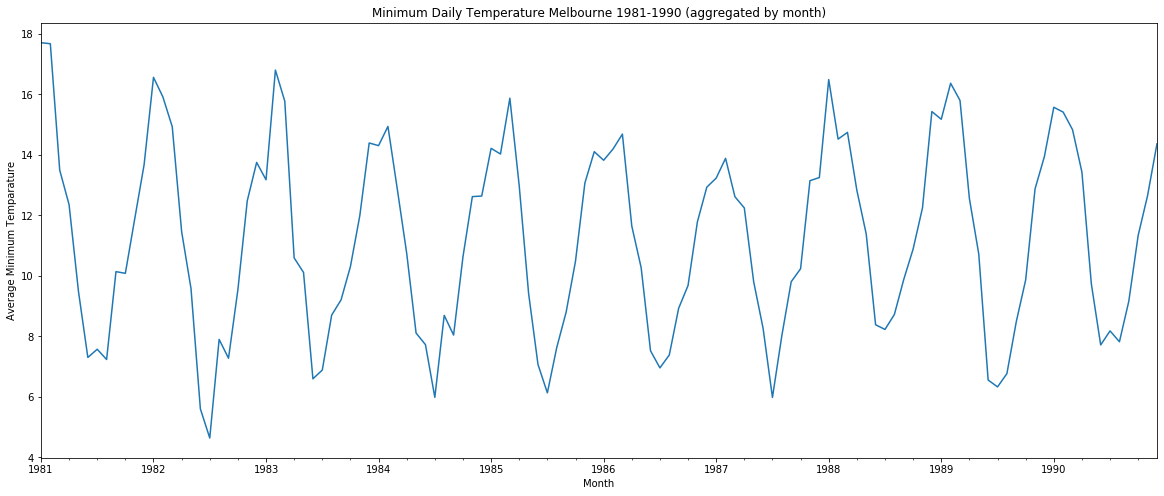

In [85]:
daily_min_temp=pd.read_csv('daily-min-temperatures.csv')
daily_min_temp['Date']=pd.to_datetime(daily_min_temp.Date, format="%d/%m/%Y")
daily_min_temp.set_index('Date',inplace=True)
by_month=daily_min_temp.resample('m').mean()

fig, ax = plt.subplots(figsize=(20,8))
by_month.Temp.plot(ax=ax)
ax.set_title('Minimum Daily Temperature Melbourne 1981-1990 (aggregated by month)')
ax.set_ylabel('Average Minimum Temparature')
ax.set_xlabel('Month')
plt.show()

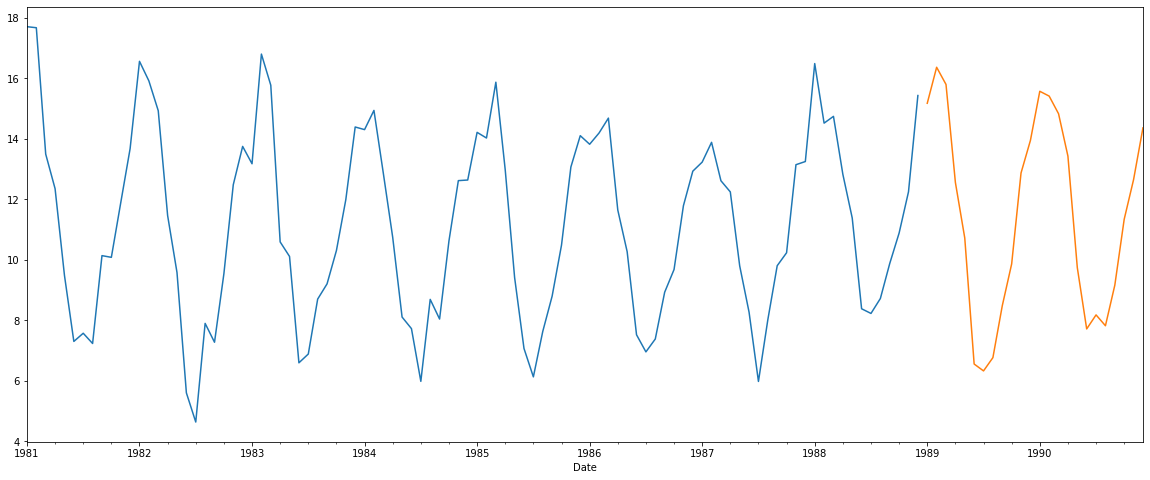

In [86]:
# Step 1, train_test_split

train=by_month['1981':'1988']
test=by_month['1989':'1990']

fig, ax = plt.subplots(figsize=(20,8))
train.Temp.plot(ax=ax)
test.Temp.plot(ax=ax)
plt.show()

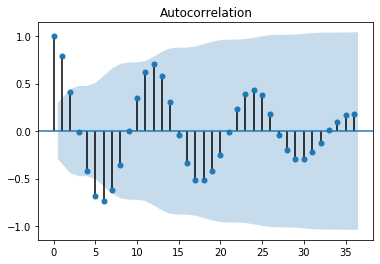

In [91]:
# Step 2: Seasonal period is 12 months (M=12)

plot_acf(train.Temp.diff(52).dropna(),lags=36) 
plt.show()

<Figure size 432x288 with 0 Axes>

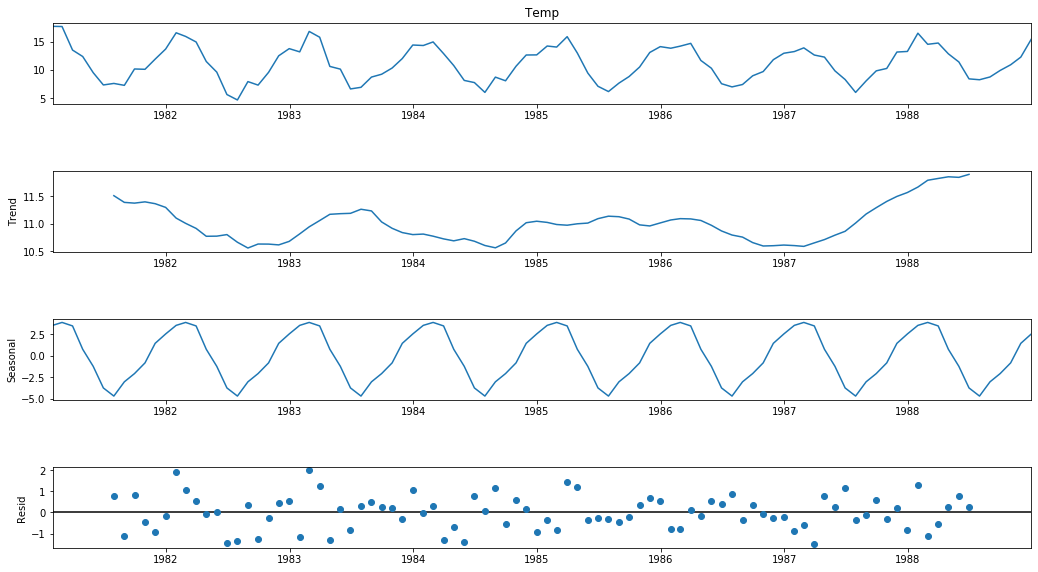

In [92]:
# Step 3, perform a seasonal decompose. Note that the seasonal part of the time series is having a huge effect

decompose = seasonal_decompose(train.Temp, period=12)  

fig = plt.figure()  
fig = decompose.plot() 
fig.set_size_inches((16, 9))

In [108]:
# Check if data is stationary

from statsmodels.tsa.stattools import adfuller

result = adfuller(train.Temp)
print('p-value: ' +str(result[1]))

p-value: 0.7763205248451919


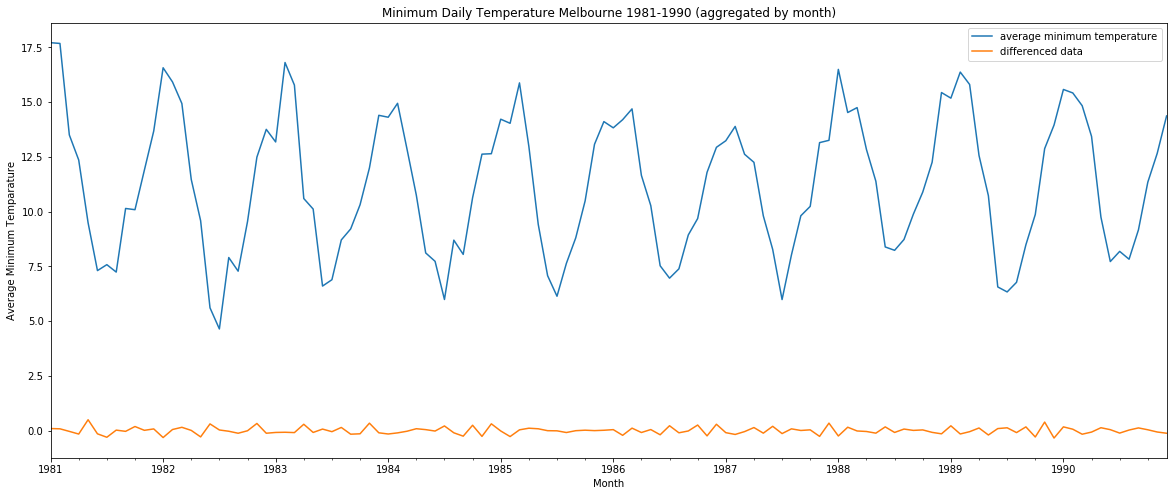

In [116]:
# It is not, so perform a simple difference on the data (d=1)

daily_min_temp['difference']=daily_min_temp.Temp.diff(periods = 1)

by_month_diff=daily_min_temp.resample('m').mean()
fig, ax = plt.subplots(figsize=(20,8))
by_month_diff.Temp.plot(ax=ax, label='average minimum temperature')
by_month_diff.seasonal_difference.plot(ax=ax,label='differenced data')
ax.set_title('Minimum Daily Temperature Melbourne 1981-1990 (aggregated by month)')
ax.set_ylabel('Average Minimum Temparature')
ax.set_xlabel('Month')
plt.legend()
plt.show()

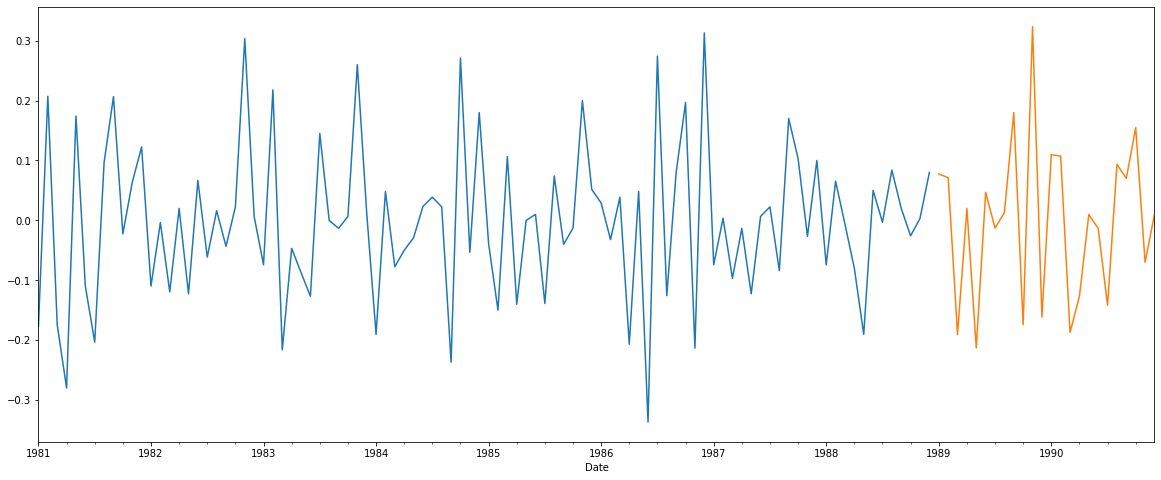

In [117]:
# redo train_test_split to apply the differenced data to our two sets

train=by_month_diff['1981':'1988']
test=by_month_diff['1989':'1990']

fig, ax = plt.subplots(figsize=(20,8))
train.difference.plot(ax=ax)
test.difference.plot(ax=ax)
plt.show()

In [119]:
# check if differenced data is stationary

result = adfuller(train.difference)
print('p-value: ' +str(result[1]))

p-value: 4.112796895175161e-08


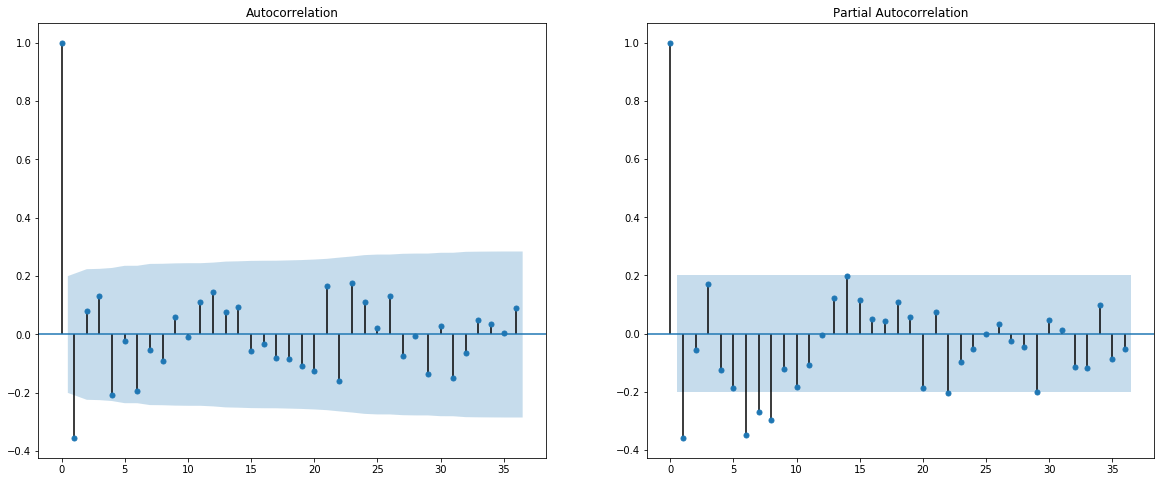

In [140]:
# It is, so we do not need to apply a seasonal difference, now check for other parameters

fig, ax = plt.subplots(ncols=2, figsize=(20,8))

plot_acf(train.difference.dropna(),lags=36,ax=ax[0]) 
plot_pacf(train.difference.dropna(),lags=36,ax=ax[1]) 
plt.show()

In [ ]:
#Based on the ACF, the first significant lag is negative, so we can ignore the AR term (p=0), 
# and also as there is only 1 significant lag in the ACF, we can set q=1

# At lag 12 on the ACF, there is no significant lag so Q=0, there are no significant lags at 12 on the PACF, so P=0

# Pulling all this together, our parameters will be (0,1,1)(0,0,0,12)

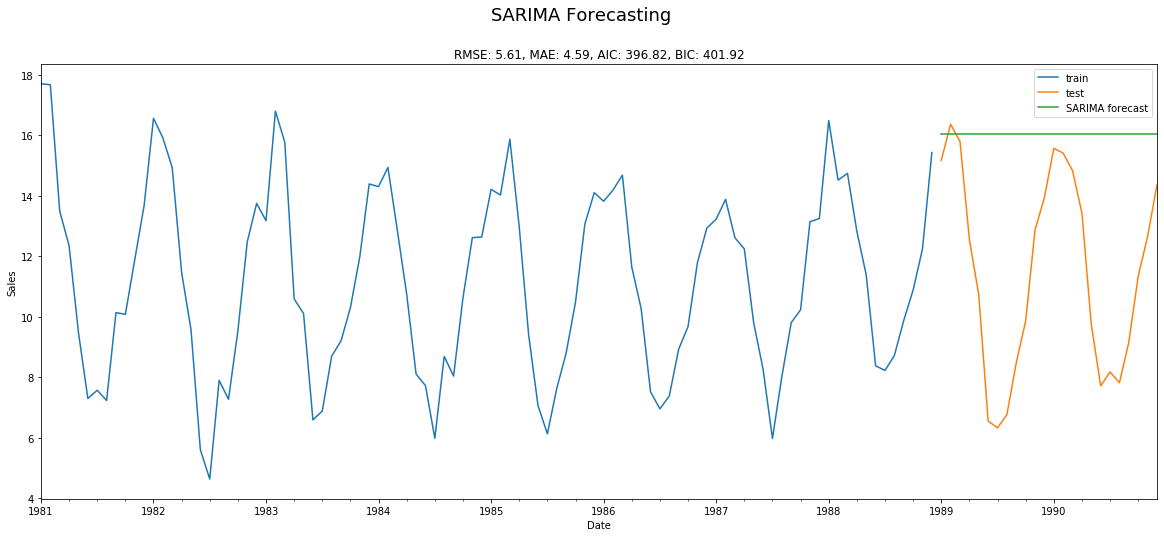

In [141]:
sarima = SARIMAX(train.Temp,order=(0,1,1),seasonal_order=(0,0,0,12)).fit()

test_sarima=test.copy() # create test set for this example

# To use this function for prediction you need to provide the first and last date
test_sarima['predicted']=sarima.predict(start=test_sarima.index[0],end=test_sarima.index[-1]) 

# calculate errors and round to 2 d.p
rmse_sarima=round(np.sqrt(mean_squared_error(test_sarima.Temp,test_sarima.predicted)),2)
mae_sarima=round(mean_absolute_error(test_sarima.Temp,test_sarima.predicted),2)
aic_sarima=round(sarima.aic,2)
bic_sarima=round(sarima.bic,2)

fig, ax = plt.subplots(figsize=(20,8))
train.Temp.plot(ax=ax,label='train')
test_sarima.Temp.plot(ax=ax,label='test')
test_sarima.predicted.plot(ax=ax,label='SARIMA forecast')
plt.legend()
plt.title('RMSE: '+str(rmse_sarima)+', MAE: '+str(mae_sarima)+', AIC: '+str(aic_sarima)+', BIC: '+str(bic_sarima))
plt.suptitle("SARIMA Forecasting",fontsize=18)
plt.ylabel('Sales')
plt.show()

In [ ]:
# This is not a great model, let's try applying a seasonal difference and calculating new parameters:

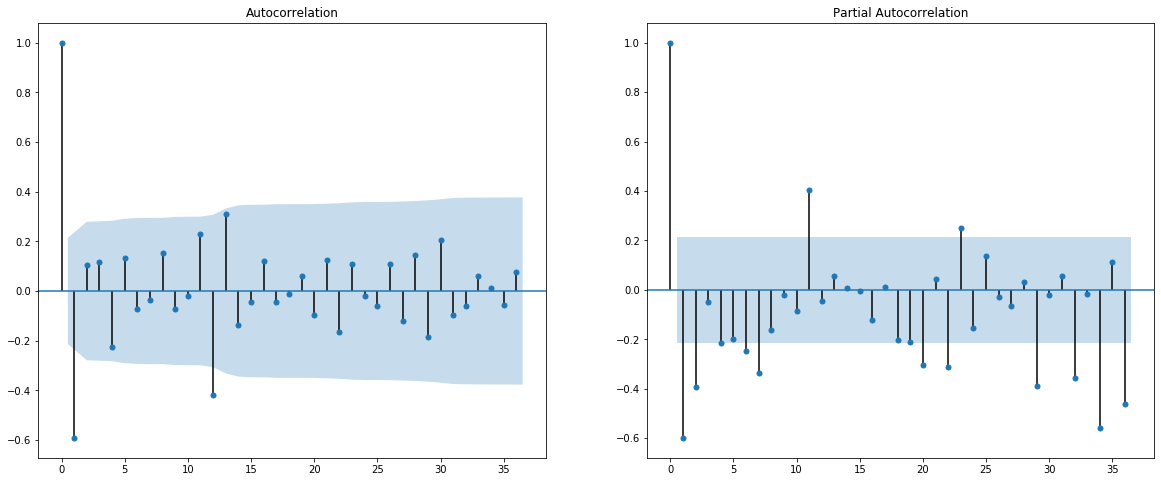

In [142]:
fig, ax = plt.subplots(ncols=2, figsize=(20,8))

plot_acf(train.difference.diff(12).dropna(),lags=36,ax=ax[0]) 
plot_pacf(train.difference.diff(12).dropna(),lags=36,ax=ax[1]) 
plt.show()

In [ ]:
# Now, based on the ACF there is one significant lag (so q=1), but on the PACF there are two significant lags (so p=2)
# As p=2, we will keep it, even though the first significant lag on the ACF is negative (so we could ignore it)

# On the ACF, at lag 12 there is one significant lag, so Q=1
# On the PACF, there are no significant lags at 12, so P=0

# M is still 12, and now because we performed a seasonal difference, D=1

# Pulling all this together, our parameters will be (2,1,1)(0,1,1,12)


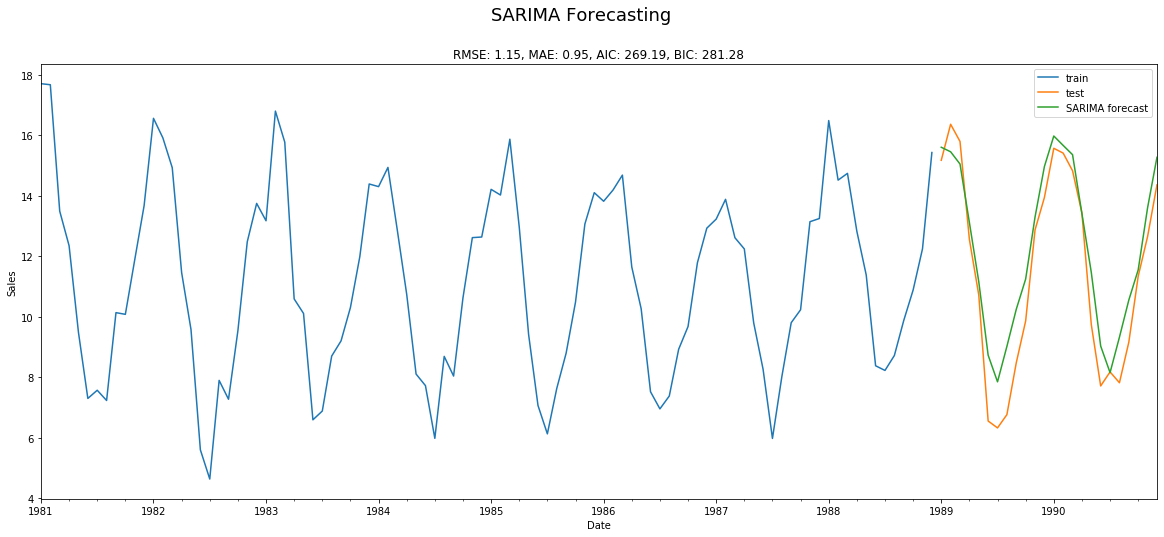

In [154]:
sarima = SARIMAX(train.Temp,order=(2,1,1),seasonal_order=(0,1,1,12)).fit()

test_sarima=test.copy() # create test set for this example

# To use this function for prediction you need to provide the first and last date
test_sarima['predicted']=sarima.predict(start=test_sarima.index[0],end=test_sarima.index[-1]) 

# calculate errors and round to 2 d.p
rmse_sarima=round(np.sqrt(mean_squared_error(test_sarima.Temp,test_sarima.predicted)),2)
mae_sarima=round(mean_absolute_error(test_sarima.Temp,test_sarima.predicted),2)
aic_sarima=round(sarima.aic,2)
bic_sarima=round(sarima.bic,2)

fig, ax = plt.subplots(figsize=(20,8))
train.Temp.plot(ax=ax,label='train')
test_sarima.Temp.plot(ax=ax,label='test')
test_sarima.predicted.plot(ax=ax,label='SARIMA forecast')
plt.legend()
plt.title('RMSE: '+str(rmse_sarima)+', MAE: '+str(mae_sarima)+', AIC: '+str(aic_sarima)+', BIC: '+str(bic_sarima))
plt.suptitle("SARIMA Forecasting",fontsize=18)
plt.ylabel('Sales')
plt.show()

In [148]:
# rebuild model now using all the data, and the best parameters

sarima = SARIMAX(by_month.Temp,order=(2,1,1),seasonal_order=(0,1,1,12)).fit()
forecasts=sarima.predict(start=by_month.index[-1],end='1991-12-31')

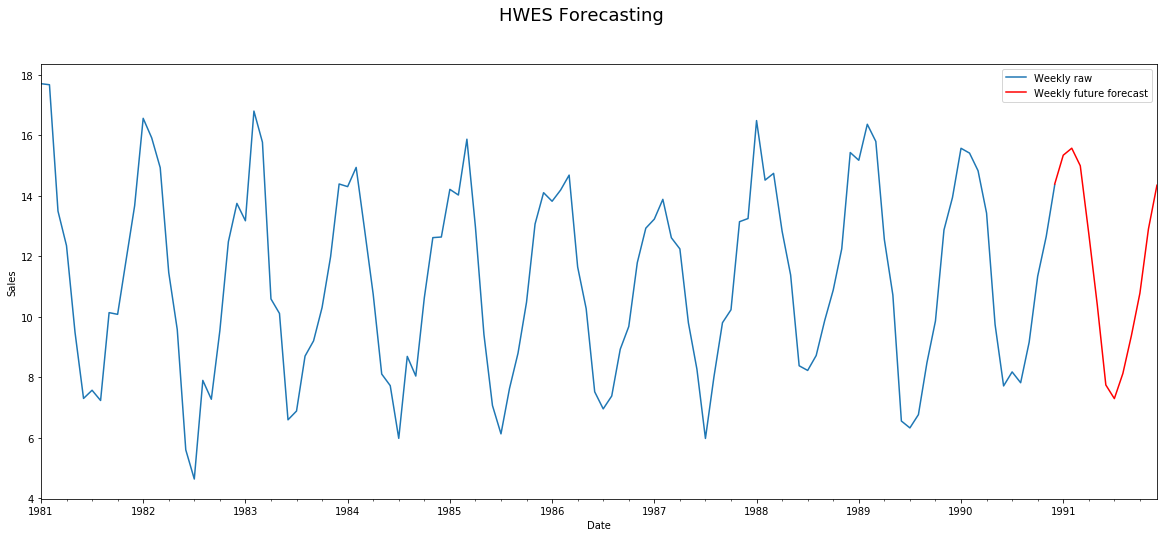

In [149]:
# plot the forecast

fig, ax = plt.subplots(figsize=(20,8))
by_month.Temp.plot(ax=ax,label='Weekly raw')
forecasts.plot(ax= ax, label = 'Weekly future forecast', color = 'red')

plt.legend()
plt.suptitle("HWES Forecasting",fontsize=18)
plt.ylabel('Sales')
plt.show()

Temp,mean,mean_se,mean_ci_lower,mean_ci_upper
1991-01-31,15.348216,1.010479,13.367713,17.328719
1991-02-28,15.579655,1.035160,13.550779,17.608531
1991-03-31,14.998957,1.076630,12.888802,17.109113
1991-04-30,12.751670,1.088653,10.617950,14.885391
1991-05-31,10.388378,1.099599,8.233204,12.543553


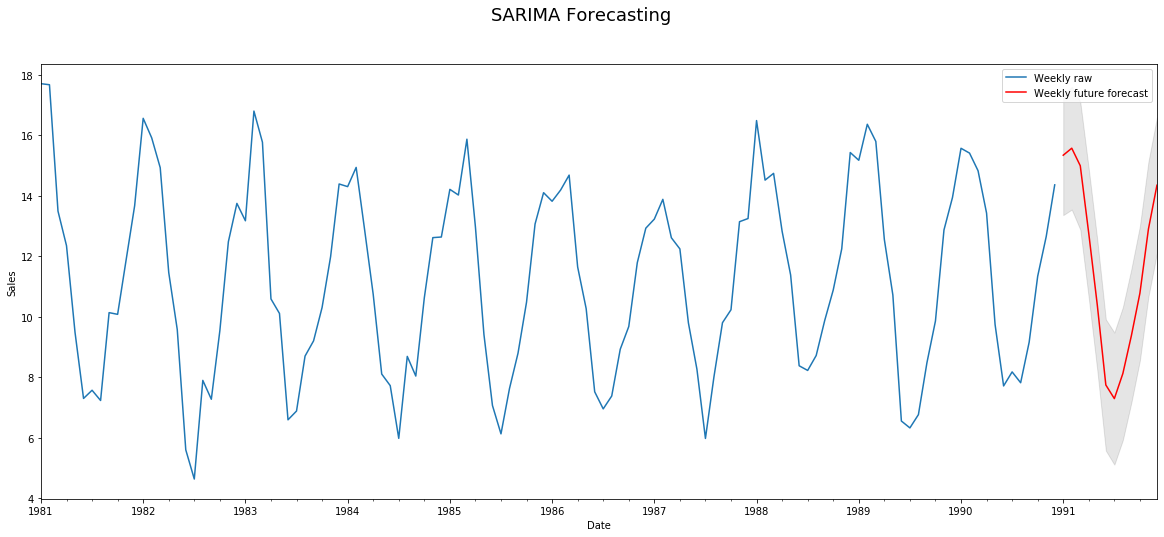

In [151]:
# SARIMA has a function that produces a forecast as well as confidence intervals

forecast = sarima.get_forecast(12).summary_frame()
display(forecast.head())

fig, ax = plt.subplots(figsize=(20,8))
by_month.Temp.plot(ax=ax,label='Weekly raw')
forecast['mean'].plot(ax= ax, label = 'Weekly future forecast', color = 'red')
ax.fill_between(forecast.index, forecast.mean_ci_lower, forecast.mean_ci_upper, color='black', alpha=0.1)

plt.legend()
plt.suptitle("SARIMA Forecasting",fontsize=18)
plt.ylabel('Sales')
plt.show()